# Mori 2023 2D Models with Axionlike Production

Neutrino spectra from a set of 2D simulations with axionlike particle production. The models are described in the paper [Multi-messenger signals of heavy axionlike particles in core-collapse supernovae: two-dimensional simulations](https://arxiv.org/abs/2304.11360) by K. Mori, T. Takiwaki, K. Kotake and S. Horiuchi, Phys. Rev. D 108:063027, 2023.

In [1]:
from snewpy.neutrino import Flavor
from snewpy.models.ccsn import Mori_2023

from astropy import units as u
from glob import glob

from scipy.interpolate import PchipInterpolator

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)

## Initialize the 2D models

Use the `param` property of the model class to see the available parameters. Models are initialized using the `axion_mass` and `axion_coupling` parameters.

In [3]:
Mori_2023.param

{'axion_mass': [0, 100, 200],
 'axion_coupling': [0, 2, 4, 6, 8, 10, 12, 14, 16, 20]}

The model with `axion_mass=0` and `axion_coupling=0` is a standard simulation with no ALP production.

In [4]:
model_std = Mori_2023(axion_mass=0, axion_coupling=0)
model_std.metadata

{'Axion mass': <Quantity 0. MeV>,
 'Axion coupling': <Quantity 0. 1 / GeV>,
 'Progenitor mass': <Quantity 20. solMass>,
 'PNS mass': <Quantity 1.78 solMass>}

In [5]:
# Catalog of axion models available.
axion_mass_coupling = [(100,2), (100,4), (100,10), (100,12), (100,14), (100,16), (100,20),
                       (200,2), (200,4), (200,6), (200,8), (200,10), (200,20)]

In [6]:
# Initialize a handful of axion models.
models = {}
for (am, ac) in ((100,2), (200,2), (100,10), (100,20), (200,10), (200,20)):
    models[(am,ac)] = Mori_2023(axion_mass=am, axion_coupling=ac)

models

{(100,
  2): Mori_2023 Model: t-prof_100_2.dat
 Axion mass       : 100.0 MeV
 Axion coupling   : 2e-10 1 / GeV
 Progenitor mass  : 20.0 solMass
 PNS mass         : 1.77 solMass,
 (200,
  2): Mori_2023 Model: t-prof_200_2.dat
 Axion mass       : 200.0 MeV
 Axion coupling   : 2e-10 1 / GeV
 Progenitor mass  : 20.0 solMass
 PNS mass         : 1.77 solMass,
 (100,
  10): Mori_2023 Model: t-prof_100_10.dat
 Axion mass       : 100.0 MeV
 Axion coupling   : 1e-09 1 / GeV
 Progenitor mass  : 20.0 solMass
 PNS mass         : 1.77 solMass,
 (100,
  20): Mori_2023 Model: t-prof_100_20.dat
 Axion mass       : 100.0 MeV
 Axion coupling   : 2e-09 1 / GeV
 Progenitor mass  : 20.0 solMass
 PNS mass         : 1.74 solMass,
 (200,
  10): Mori_2023 Model: t-prof_200_10.dat
 Axion mass       : 200.0 MeV
 Axion coupling   : 1e-09 1 / GeV
 Progenitor mass  : 20.0 solMass
 PNS mass         : 1.73 solMass,
 (200,
  20): Mori_2023 Model: t-prof_200_20.dat
 Axion mass       : 200.0 MeV
 Axion coupling   : 2e-09

## Plot Model Luminosities

Compare axion model luminosity to the standard 2D simulation.

Higher mass models with stronger coupling constants should produce a decrease in neutrino luminosity at all flavors relative to the reference simulation.

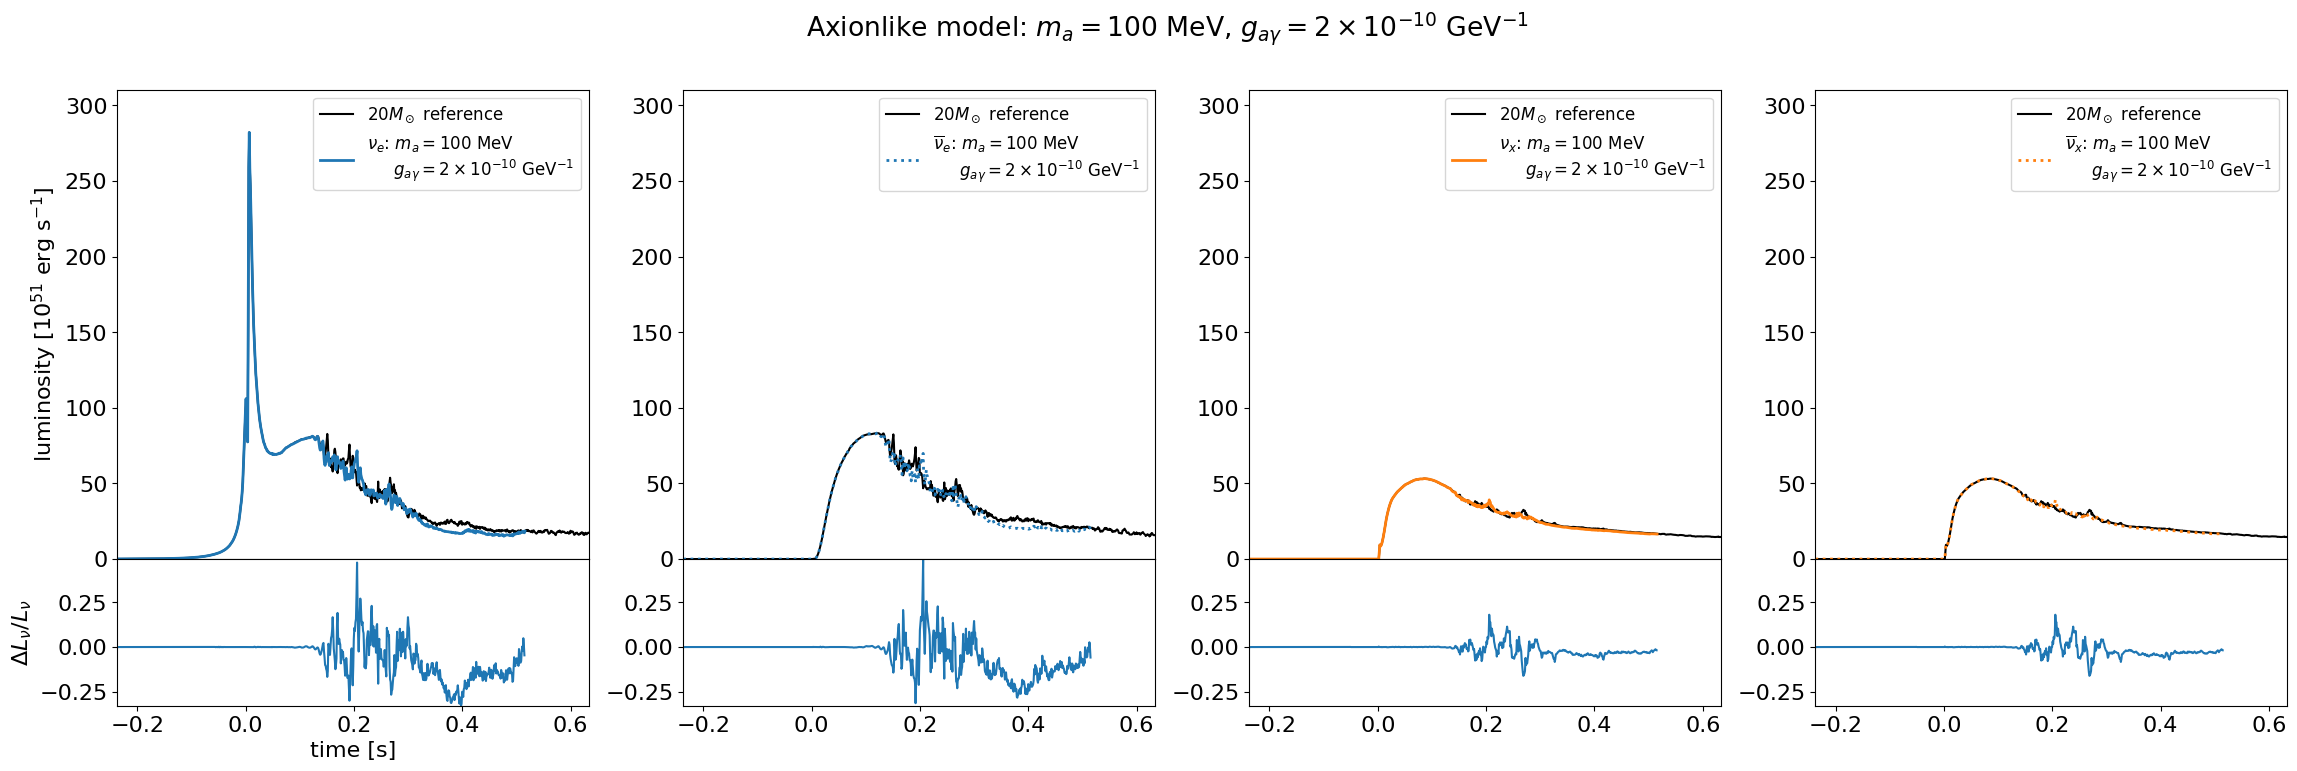

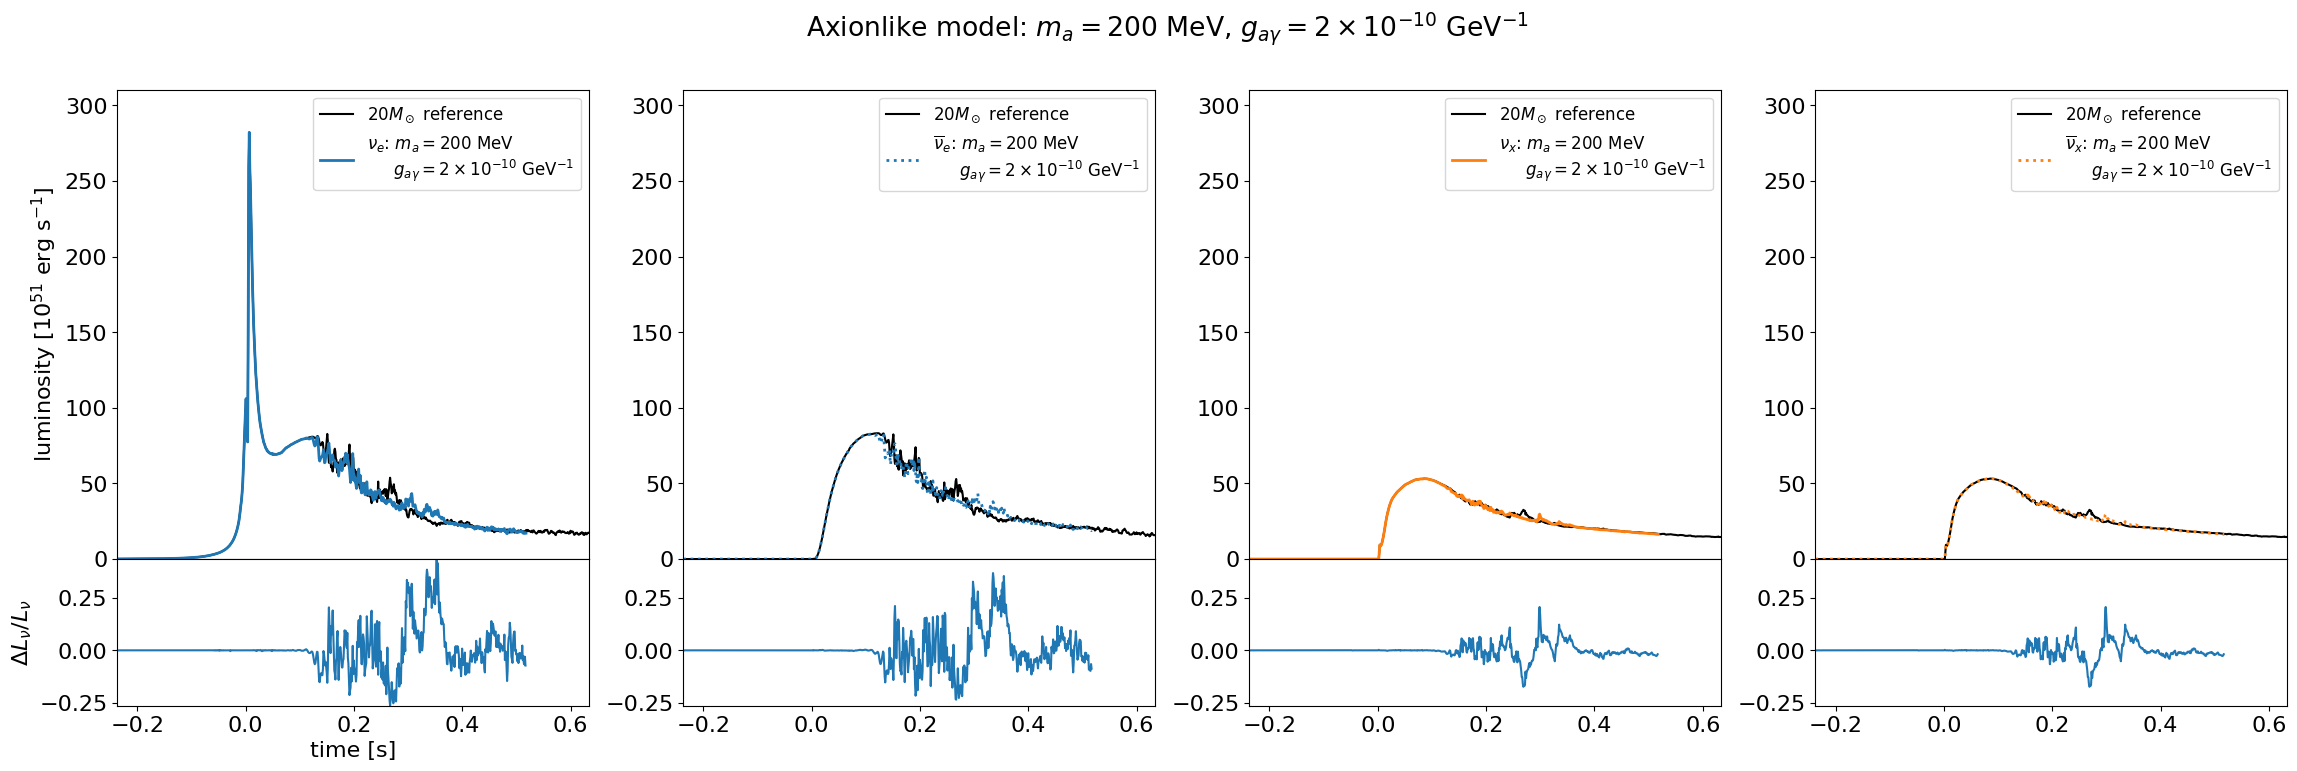

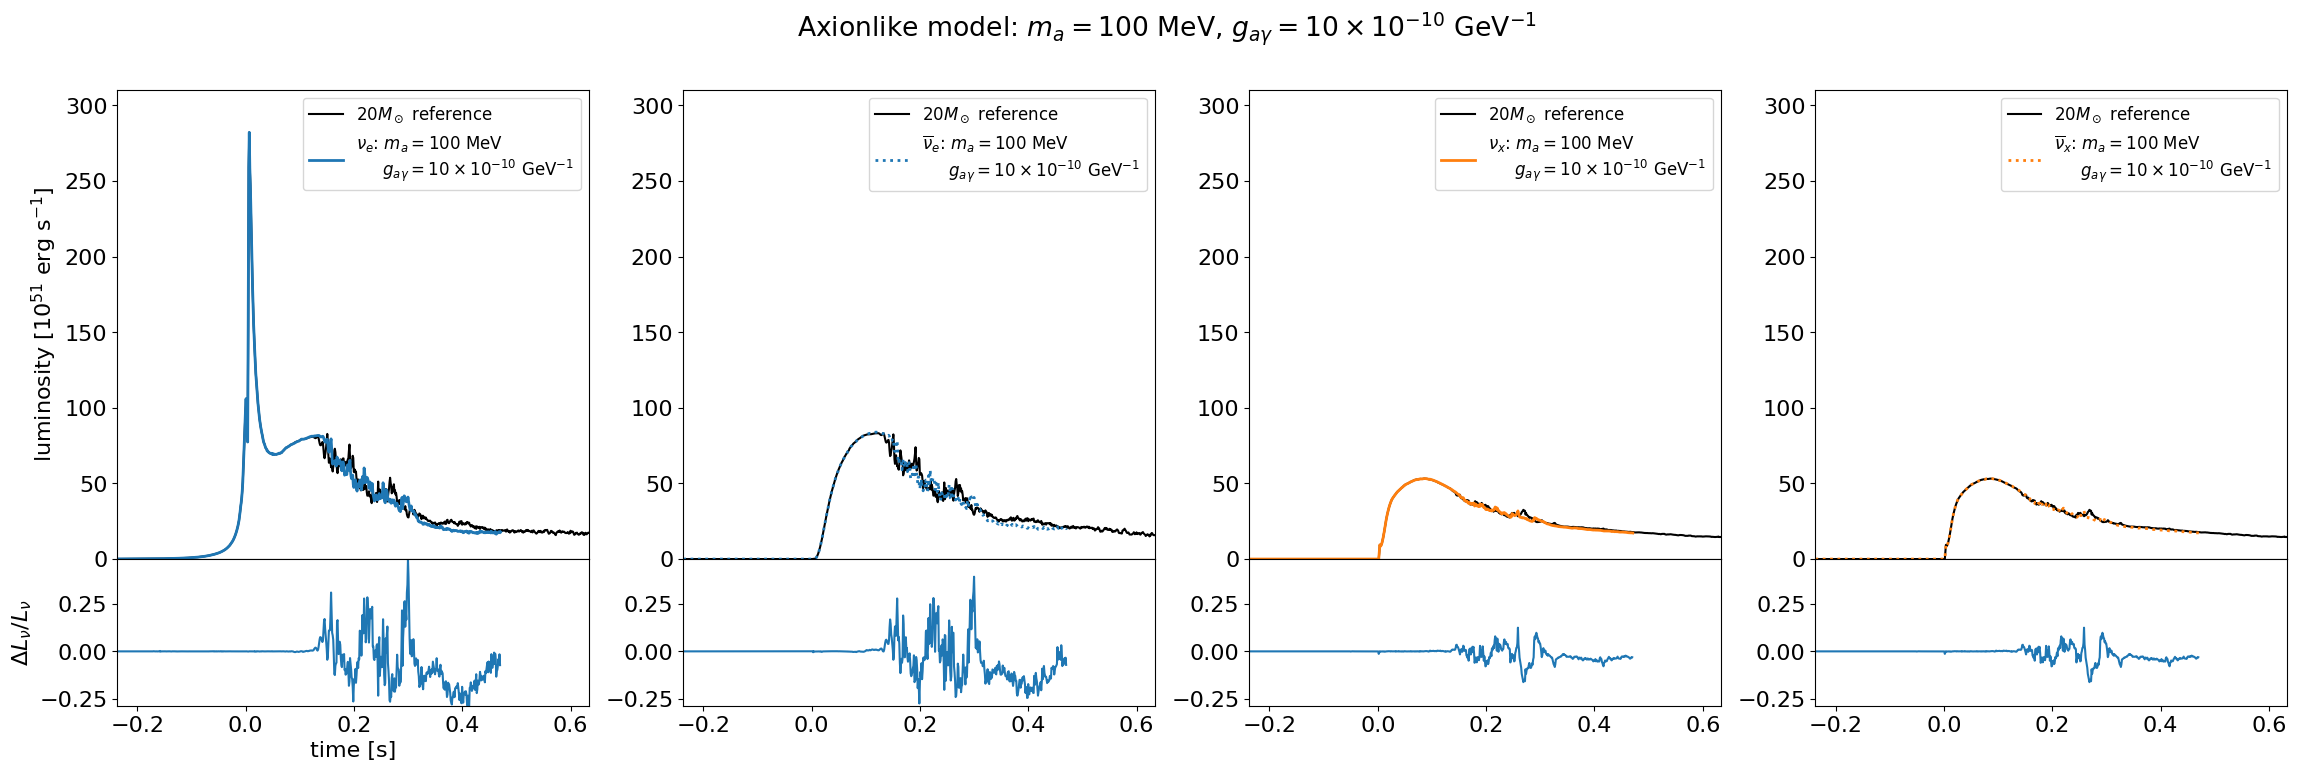

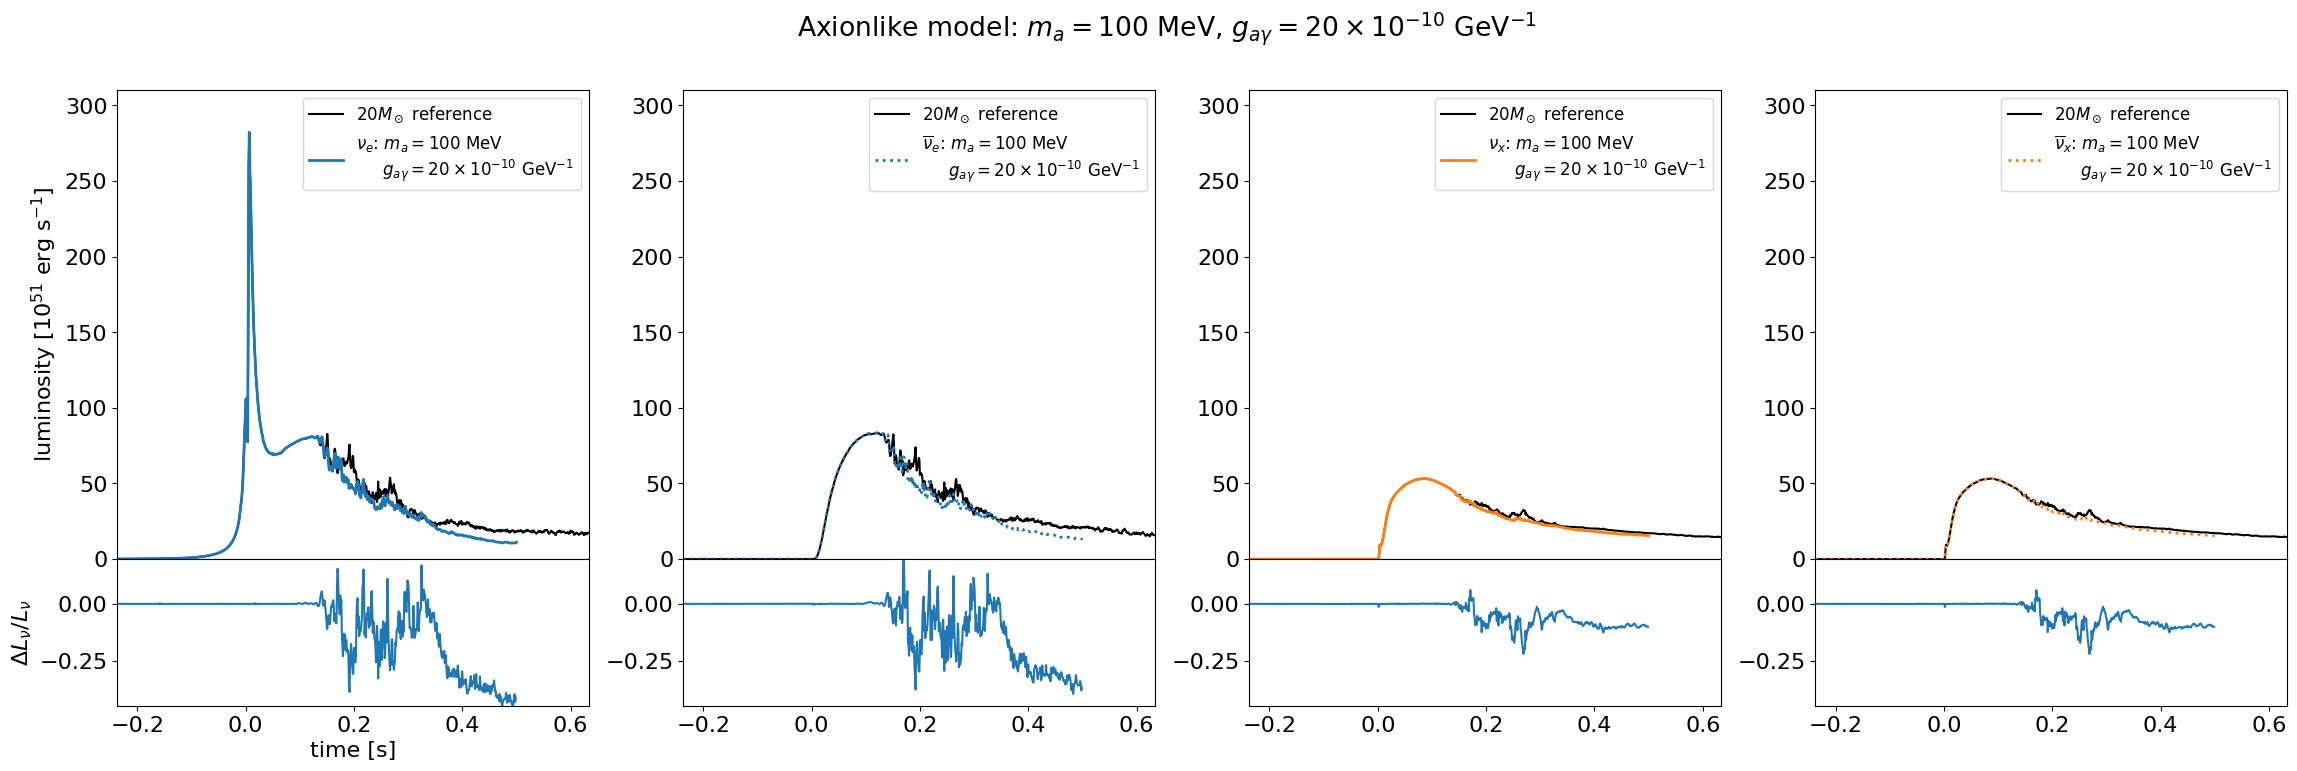

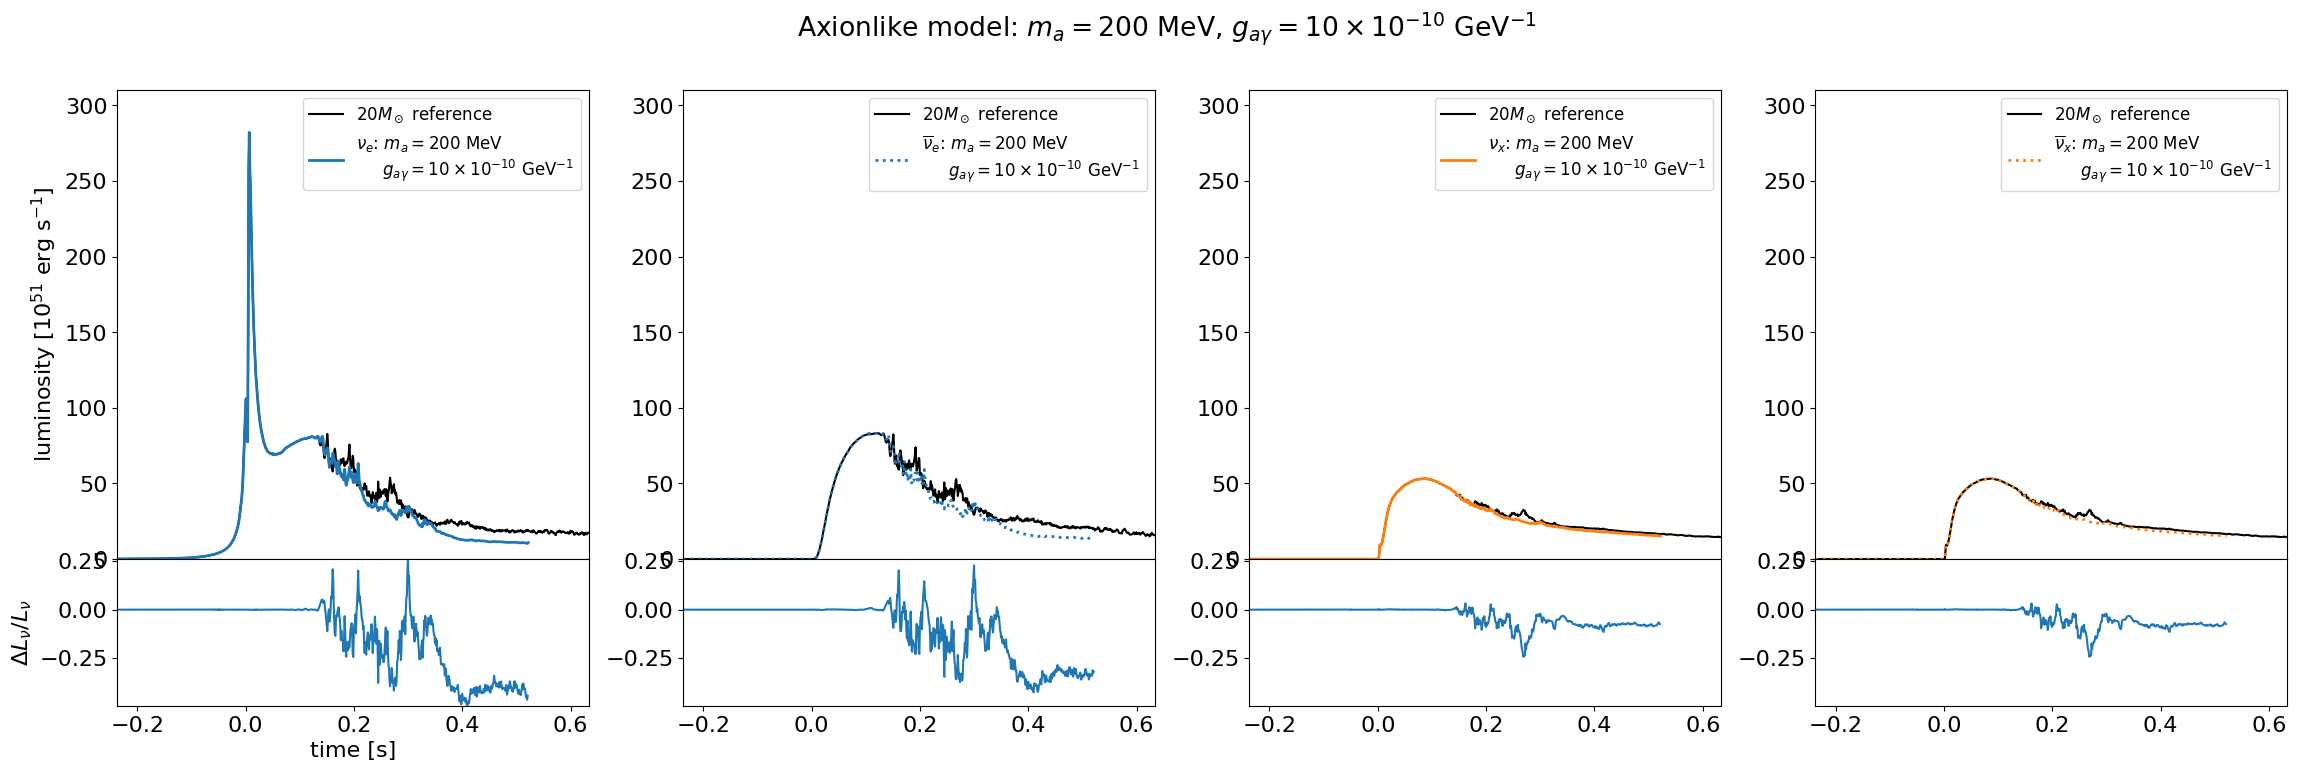

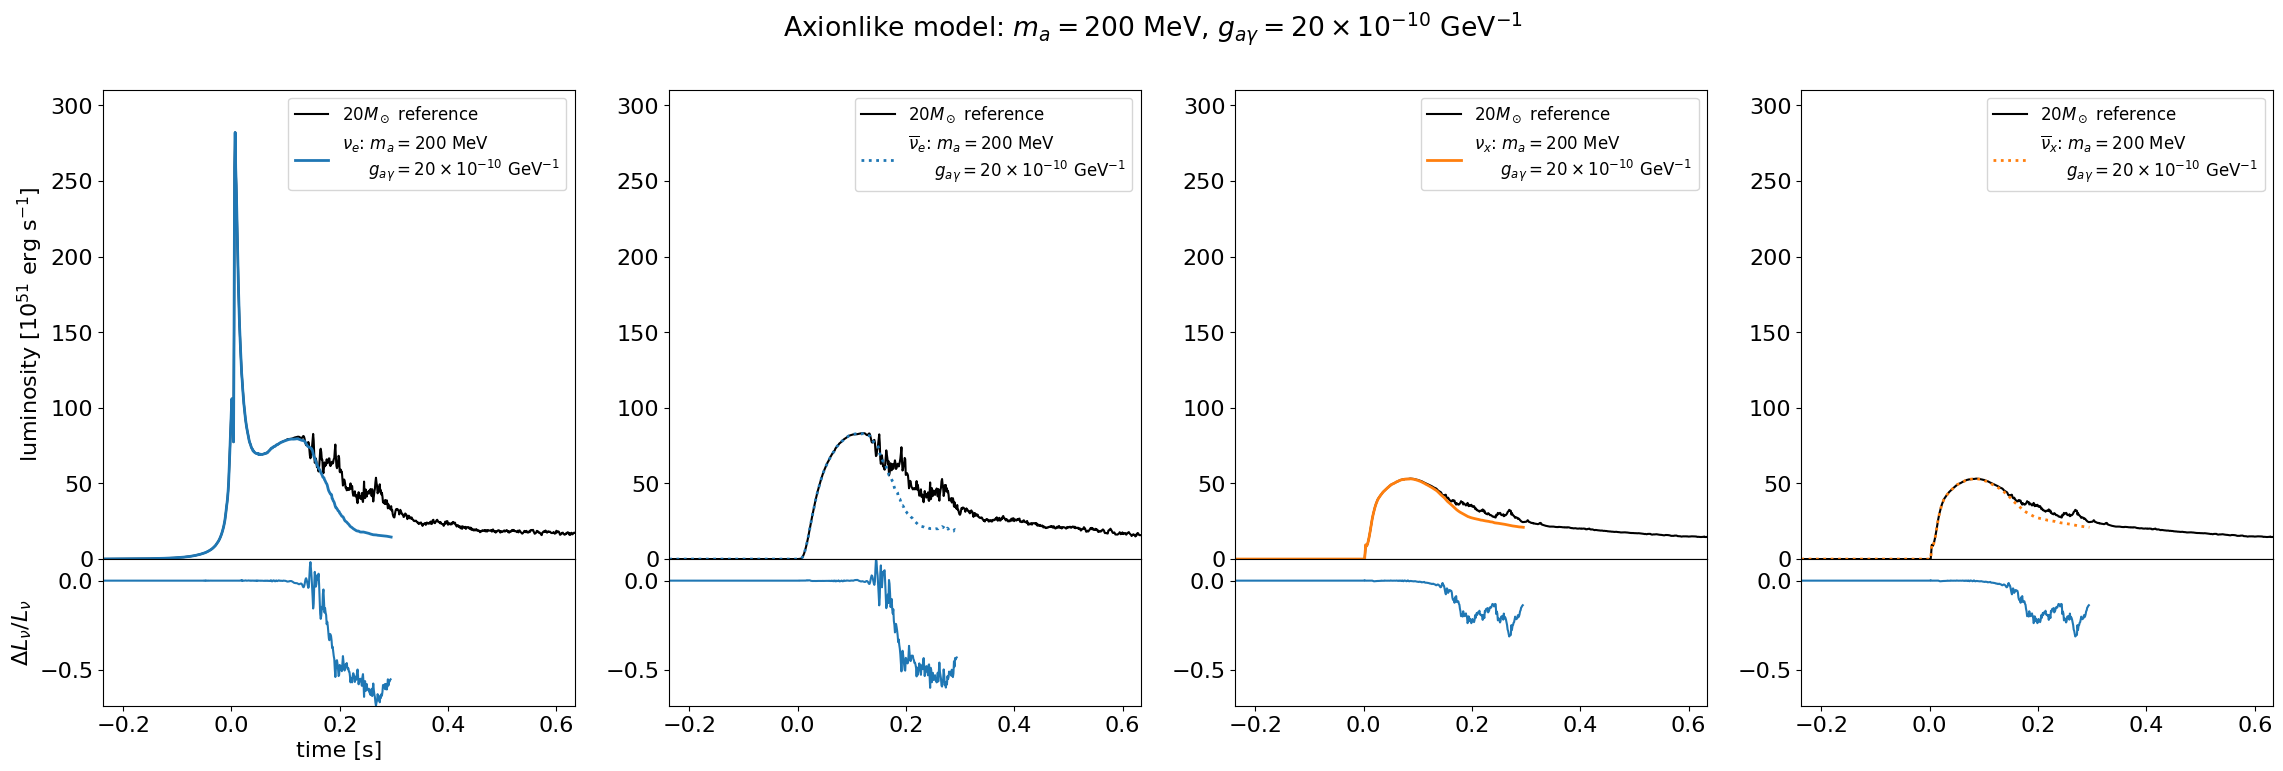

In [7]:
for (m,c), model in models.items():
    
    fig, axes = plt.subplots(2, 4, figsize=(28, 8), sharex=True,
                         gridspec_kw={'height_ratios':[3.2,1], 'hspace':0})
    
    Lmin,  Lmax  = 1e99, -1e99
    dLmin, dLmax = 1e99, -1e99
    
    for j, (flavor) in enumerate([Flavor.NU_E, Flavor.NU_E_BAR, Flavor.NU_X, Flavor.NU_X_BAR]):
        ax = axes[0][j]
        
        ax.plot(model_std.time, model_std.luminosity[flavor]/1e51, 'k', label='$20M_\odot$ reference')  # Report luminosity in [foe/s]
        Lmin = np.minimum(Lmin, np.min(model_std.luminosity[flavor].to_value('1e51 erg/s')))
        Lmax = np.maximum(Lmax, np.max(model_std.luminosity[flavor].to_value('1e51 erg/s')))
        
        modlabel = '{}: $m_a={}$ MeV\n     $g_{{a\gamma}}={}\\times10^{{-10}}$ GeV$^{{-1}}$'.format(flavor.to_tex(), m, c)
        ax.plot(model.time, model.luminosity[flavor]/1e51,  # Report luminosity in units foe/s
                label=modlabel,
                color='C0' if flavor.is_electron else 'C1',
                ls='-' if flavor.is_neutrino else ':',
                lw=2)
        if j==0:
            ax.set(ylabel=r'luminosity [$10^{51}$ erg s$^{-1}$]')
        
        ax.legend(fontsize=12)
        ax.set(xlim=(model_std.time[0].to_value('s'), model_std.time[-1].to_value('s')))
        
        ax = axes[1][j]
        tmin = np.maximum(model.time[0], model_std.time[0]).to_value('s')
        tmax = np.minimum(model.time[-1], model_std.time[-1]).to_value('s')
        times = np.arange(tmin, tmax, 0.001)*u.s

        Lstd = PchipInterpolator(model_std.time, model_std.luminosity[flavor].to_value('1e51 erg/s'))
        Lstd_t = Lstd(times)
        select = Lstd_t != 0
        
        Lmod = PchipInterpolator(model.time, model.luminosity[flavor].to_value('1e51 erg/s'))
        Lmod_t = Lmod(times)
        dL = (Lmod_t[select] - Lstd_t[select]) / Lstd_t[select]
        
        dLmin = np.minimum(dLmin, np.min(dL))
        dLmax = np.maximum(dLmax, np.max(dL))

        ax.plot(times[select], dL)
        if j==0:
            ax.set(xlabel='time [s]',
                   ylabel=r'$\Delta L_\nu/L_\nu$')
            
    for j in range(4):
        axes[0][j].set(ylim=(Lmin, 1.1*Lmax))
        axes[1][j].set(ylim=(dLmin, dLmax))
        
    fig.suptitle('Axionlike model: $m_a={}$ MeV, $g_{{a\gamma}}={}\\times10^{{-10}}$ GeV$^{{-1}}$'.format(m, c))
